In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

from manuscript import iterate_subsamples_over_notebooks

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")

In [3]:
import matplotlib.pyplot as plt

In [4]:
in_user = 'general'     # defines top hierarchy of input folder
in_mainstem = '40_iterate_after_subsampling_patients'    


out_user = 'general'     # defines top hierarchy of output folder
outfolder = '41_analyze_after_subsampling_patients'    # name of notebook
save = True

In [5]:
def dump_figure(name):
    if save:
        export.image(
            out_user,
            f'{outfolder}/{name}',
        )

In [6]:
def dump_table(df, name):
    if save:
        export.full_frame(
            out_user, 
            f'{outfolder}/{name}', 
            df, 
            index=True,
            date=False
        )

In [7]:
failed = []

In [8]:
def get_stats(subpath):
    agg = []

    for boot in ['all'] + [int(x) for x in range(1, 501)]:
    # for boot in [int(x) for x in range(200, 232)]:

        if boot != 'all':
            boot = f'{boot}'.zfill(4)


        outstem = f'{in_mainstem}/{boot}/'


        p = inout.get_material_path(
            os.path.join(in_user, outstem, subpath)
        ) #  outstemaa

        df = pd.read_excel(p)
        df.loc[:, 'boot'] = boot
        agg.append(df)
        
    df = pd.concat(agg)
    return df
#    

In [9]:
df = get_stats('06_covid-analysis/n-days-per-cluster_stats.xlsx')

In [10]:
df['significant'] = df['pval_adj'] < 0.05
df['longer_in_covid'] = df['group2_median'] > df['group1_median']

In [11]:
df[df['boot']=='all'].sort_values(['significant', 'longer_in_covid'], ascending=False)

,variable,value,group1,group2,group1_size,group2_size,pval,group1_median,group2_median,pval_adj,boot,significant,longer_in_covid
2,cluster,5,False,True,79,129,1.264980e-04,1.0,3.0,0.000354,all,True,True
4,cluster,10,False,True,132,115,3.983523e-07,2.0,3.0,0.000002,all,True,True
5,cluster,11,False,True,47,51,1.099036e-05,2.0,15.0,0.000038,all,True,True
6,cluster,1,False,True,115,89,1.624799e-07,2.0,4.0,0.000002,all,True,True
9,cluster,13,False,True,35,80,5.631732e-03,2.0,4.0,0.011263,all,True,True
12,cluster,2,False,True,83,52,4.271449e-07,2.0,8.0,0.000002,all,True,True
0,cluster,3,False,True,168,58,2.834774e-03,3.0,2.0,0.006614,all,True,False
3,cluster,6,False,True,47,75,2.950588e-02,2.0,4.0,0.051635,all,False,True
11,cluster,14,False,True,130,34,4.353034e-01,2.0,2.5,0.468788,all,False,True
13,cluster,12,False,True,14,16,2.670864e-01,5.0,11.0,0.311601,all,False,True


In [12]:
df = df[df['boot']!='all'].copy()

In [13]:
if not df[df['significant']]['boot'].nunique() == df['boot'].nunique():
    raise AssertionError('at least one iteration did not have any significant differnce')

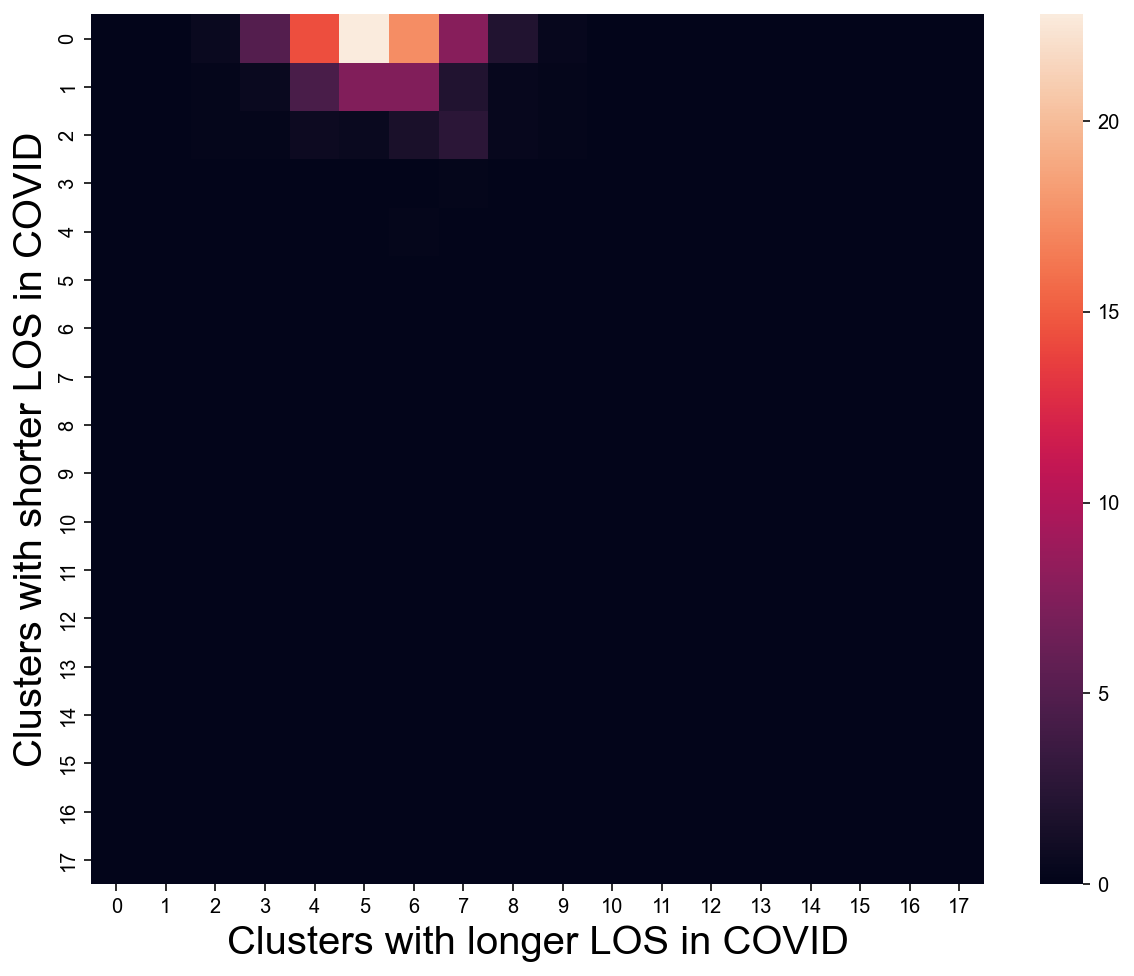

In [14]:
sns.heatmap(
    df[df['significant']].groupby(['boot', 'longer_in_covid']).size().to_frame('c').reset_index().pivot(
        index='boot', columns='longer_in_covid', values='c'
    ).fillna(0).groupby([False, True]).size().to_frame('tot').reset_index().pivot(
        index=False, columns=True, values='tot').fillna(0).reindex(index=range(0, 18), columns=range(0, 18)).fillna(0) / 5
)

plt.xlabel('Clusters with longer LOS in COVID', fontsize=20)
plt.ylabel('Clusters with shorter LOS in COVID', fontsize=20)
dump_figure('absolute_clusters.pdf')

In [15]:
df

,variable,value,group1,group2,group1_size,group2_size,pval,group1_median,group2_median,pval_adj,boot,significant,longer_in_covid
0,cluster,1,False,True,43,38,4.972036e-04,2.0,6.5,1.740213e-03,0001,True,True
1,cluster,3,False,True,177,99,7.648643e-02,2.0,3.0,1.273530e-01,0001,False,True
2,cluster,4,False,True,91,87,8.496074e-06,2.0,4.0,5.947252e-05,0001,True,True
3,cluster,13,False,True,82,111,1.389403e-08,2.0,5.0,1.945164e-07,0001,True,True
4,cluster,12,False,True,18,36,2.758727e-02,3.5,13.5,6.437029e-02,0001,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,cluster,10,False,True,111,24,7.998282e-02,2.0,3.5,1.599656e-01,0500,False,True
10,cluster,6,False,True,11,38,4.619659e-01,3.0,5.5,5.442979e-01,0500,False,True
11,cluster,9,False,True,189,36,2.400202e-01,3.0,2.0,3.733647e-01,0500,False,False
12,cluster,5,False,True,104,20,6.252399e-02,2.5,3.5,1.458893e-01,0500,False,True


In [16]:
helper = df[df['significant']].groupby('boot')['longer_in_covid'].mean().to_frame('share')

In [17]:
f = helper['share'] < 0.5
helper.loc[f, 'kind'] = 'mostly shorter in COVID'

f = helper['share'] > 0.5
helper.loc[f, 'kind'] = 'mostly longer in COVID'

f = helper['share'] == 0
helper.loc[f, 'kind'] = 'always shorter in COVID'

f = helper['share'] == 1
helper.loc[f, 'kind'] = 'always longer in COVID'

f = helper['share'] == 0.5
helper.loc[f, 'kind'] = 'equal in COVID'

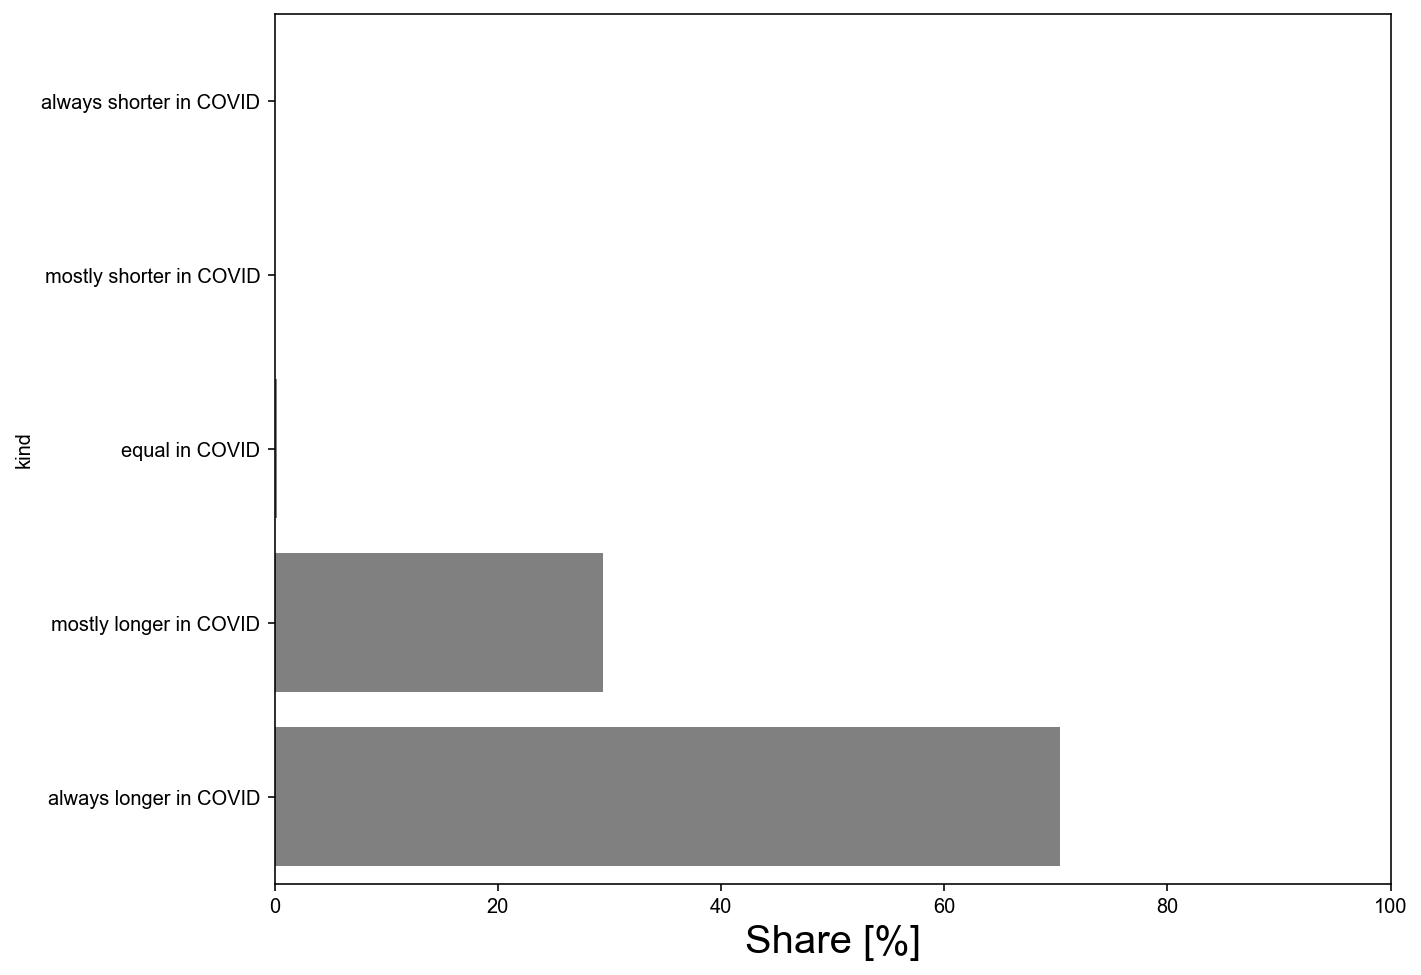

In [18]:
sns.barplot(
    y='kind',
    x='share',
    estimator=lambda x: 100*(len(x)/helper.shape[0]),
    data=helper,
    order=[
        'always shorter in COVID',
        'mostly shorter in COVID',
        'equal in COVID',
        'mostly longer in COVID',
        'always longer in COVID',        
    ],
    color='grey'
)

plt.xlim(0, 100)
plt.xlabel('Share [%]', fontsize=20)

dump_figure('normalized_duration.pdf')

In [19]:
helper['kind'].value_counts() / helper.shape[0]

always longer in COVID    0.704
mostly longer in COVID    0.294
equal in COVID            0.002
Name: kind, dtype: float64

In [20]:
helper['kind'].value_counts()

always longer in COVID    352
mostly longer in COVID    147
equal in COVID              1
Name: kind, dtype: int64

In [21]:
df = get_stats('06_covid-analysis/norm-transitions-binary_stats.xlsx')

In [22]:
df = df[df['variable']=='discharge'].copy()

In [23]:
df[df['boot']=='all']

,variable,value,group1,group2,group1_size,group2_size,pval,group1_median,group2_median,pval_adj,boot
2,discharge,Lived,False,True,220,103,0.003140,0.375000,0.3125,0.003140,all
3,discharge,Died,False,True,175,87,0.000616,0.294118,0.2000,0.000821,all


In [24]:
df = df[df['boot']!='all']

In [25]:
df['boot'].nunique()

500

In [26]:

df['significant'] = df['pval_adj'] < 0.05
# df['shorter_in_covid'] = df['group2_median'] < df['group1_median']

In [27]:
f = (df['group2_median'] < df['group1_median']) & (df['significant'])
df.loc[f, 'kind'] = 'shorter in COVID and significant'

f = (df['group2_median'] < df['group1_median']) & (~df['significant'])
df.loc[f, 'kind'] = 'shorter in COVID not significant'

f = (df['group2_median'] > df['group1_median']) & (df['significant'])
df.loc[f, 'kind'] = 'longer in COVID and significant'

f = (df['group2_median'] > df['group1_median']) & (~df['significant'])
df.loc[f, 'kind'] = 'longer in COVID not significant'
                                                   
f = df['group2_median'] == df['group1_median']
df.loc[f, 'kind'] = 'equal'

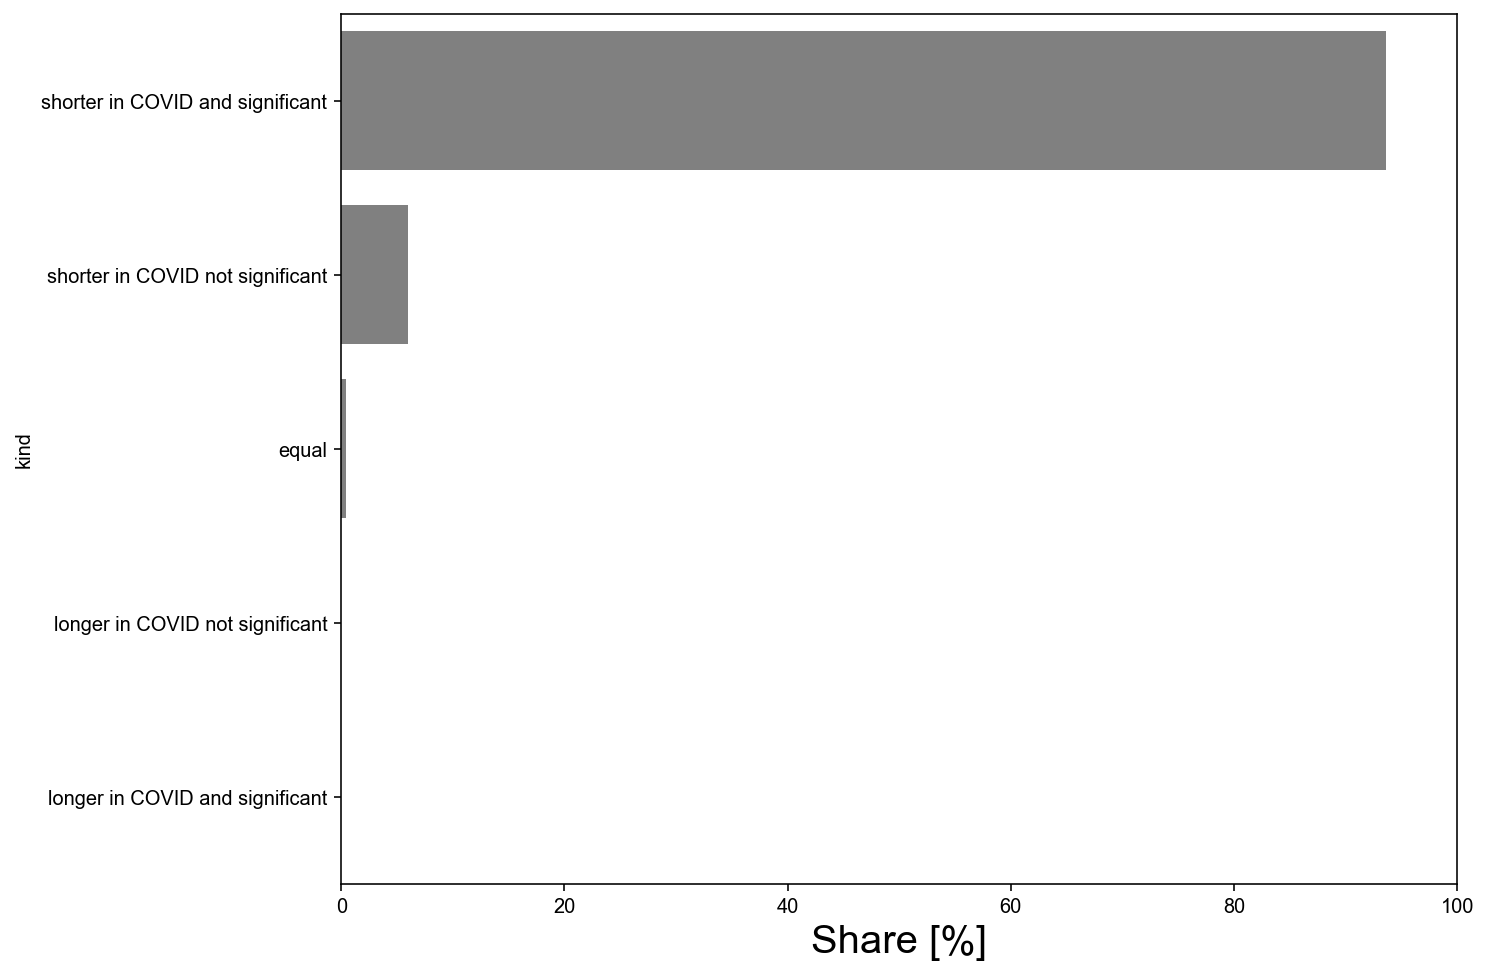

In [28]:
helper = df[df['value']=='Lived']

sns.barplot(
    y='kind',
    x='group1_median',
    estimator=lambda x: 100*(len(x)/helper.shape[0]),
    data=helper,
    order=[
        'shorter in COVID and significant',
        'shorter in COVID not significant',
        'equal',
        'longer in COVID not significant',
        'longer in COVID and significant'
        
        
    ],


  color='grey'
)

plt.xlim(0, 100)
plt.xlabel('Share [%]', fontsize=20)

dump_figure('lived.pdf')

In [29]:
helper['kind'].value_counts() / helper.shape[0]

shorter in COVID and significant    0.936
shorter in COVID not significant    0.060
equal                               0.004
Name: kind, dtype: float64

In [30]:
helper['kind'].value_counts()

shorter in COVID and significant    468
shorter in COVID not significant     30
equal                                 2
Name: kind, dtype: int64

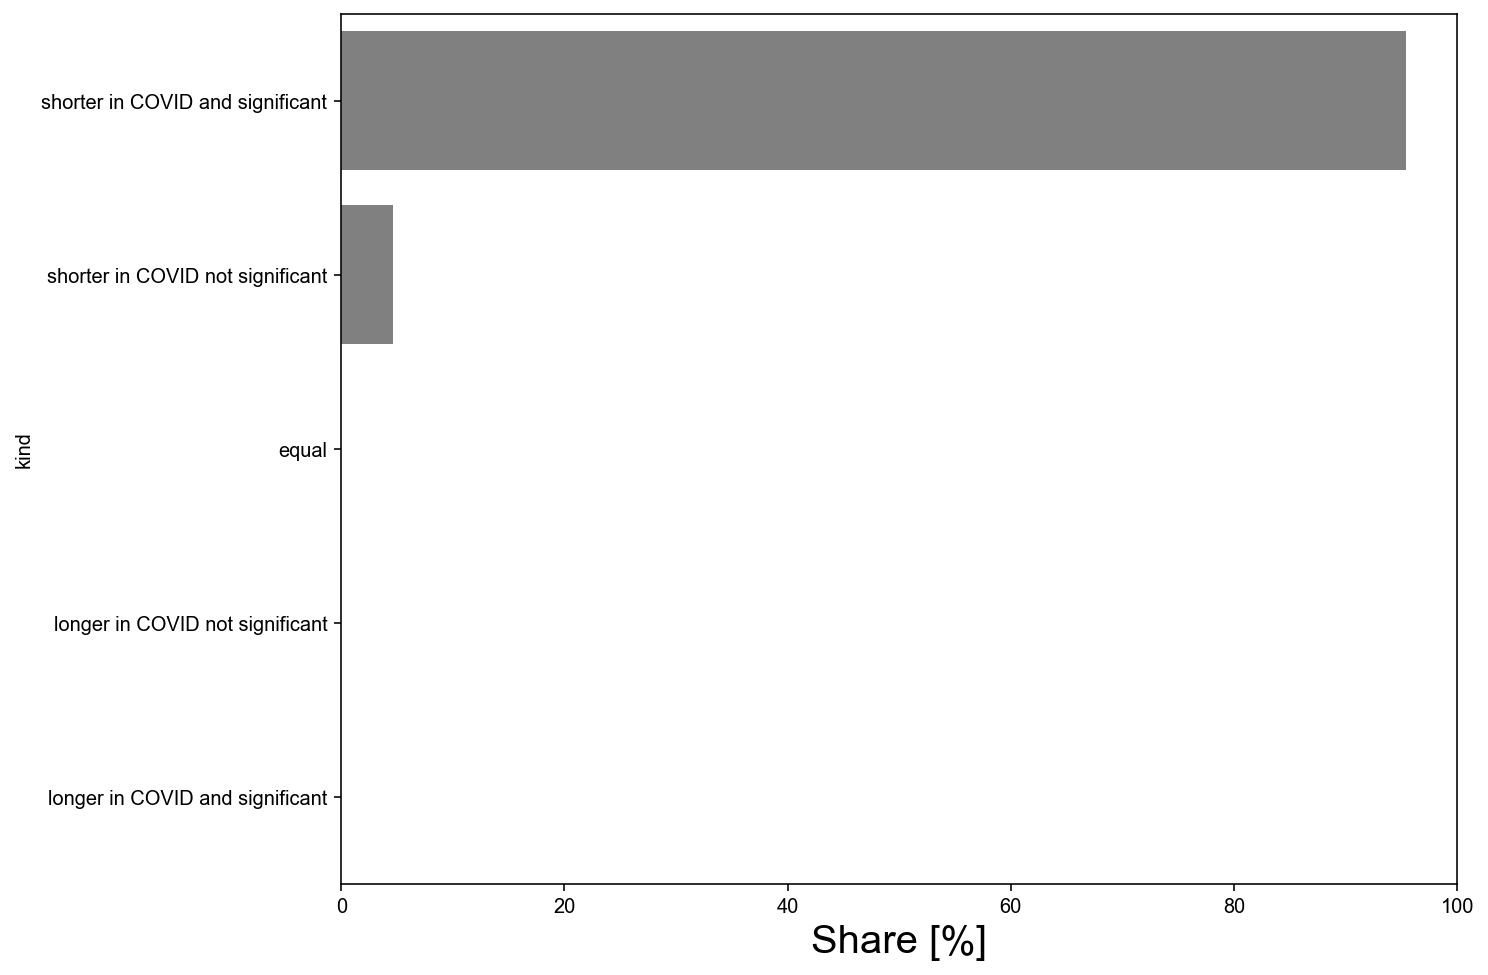

In [31]:
helper = df[df['value']=='Died']

sns.barplot(
    y='kind',
    x='group1_median',
    estimator=lambda x: 100*(len(x)/helper.shape[0]),
    data=helper,
    order=[
        'shorter in COVID and significant',
        'shorter in COVID not significant',
        'equal',
        'longer in COVID not significant',
        'longer in COVID and significant'
        
        
    ],


  color='grey'
)

plt.xlim(0, 100)
plt.xlabel('Share [%]', fontsize=20)

dump_figure('died.pdf')

In [32]:
helper['kind'].value_counts() / helper.shape[0]

shorter in COVID and significant    0.954
shorter in COVID not significant    0.046
Name: kind, dtype: float64

In [33]:
helper['kind'].value_counts()

shorter in COVID and significant    477
shorter in COVID not significant     23
Name: kind, dtype: int64

In [34]:
df = get_stats('10_VAP_transitions/vap_sum_of_trans_7days_stats.xlsx')

In [35]:
df[df['boot']=='all']

,group1,group2,group1_size,group2_size,pval,group1_median,group2_median,group1_mean,group2_mean,pval_two_sided,pval_adj,pval_adj_two,boot
0,Cured,Indeterminate,128,73,1.056864e-03,-0.017087,0.000000,-0.100837,0.005777,1.056864e-03,1.453947e-03,1.453947e-03,all
1,Cured,Not cured,128,78,4.363561e-09,-0.017087,0.004668,-0.100837,0.153731,4.363561e-09,1.309068e-08,1.309068e-08,all
2,Indeterminate,Not cured,73,78,1.453947e-03,0.000000,0.004668,0.005777,0.153731,1.453947e-03,1.453947e-03,1.453947e-03,all


In [36]:
df = df[df['boot']!='all'].copy()

In [37]:
df = df[(df['group1']=='Cured') & (df['group2']=='Not cured')].copy()

In [38]:
df['significant'] = df['pval_adj'] < 0.05

In [39]:
f = (df['group2_median'] < df['group1_median']) & (df['significant'])
df.loc[f, 'kind'] = 'fewer in non-cured (significant)'

f = (df['group2_median'] < df['group1_median']) & (~df['significant'])
df.loc[f, 'kind'] = 'fewer in non-cured (not significant)'

f = (df['group2_median'] > df['group1_median']) & (df['significant'])
df.loc[f, 'kind'] = 'more in non-cured (significant)'

f = (df['group2_median'] > df['group1_median']) & (~df['significant'])
df.loc[f, 'kind'] = 'more in non-cured (not significant)'
                                                   
f = df['group2_median'] == df['group1_median']
df.loc[f, 'kind'] = 'equal'

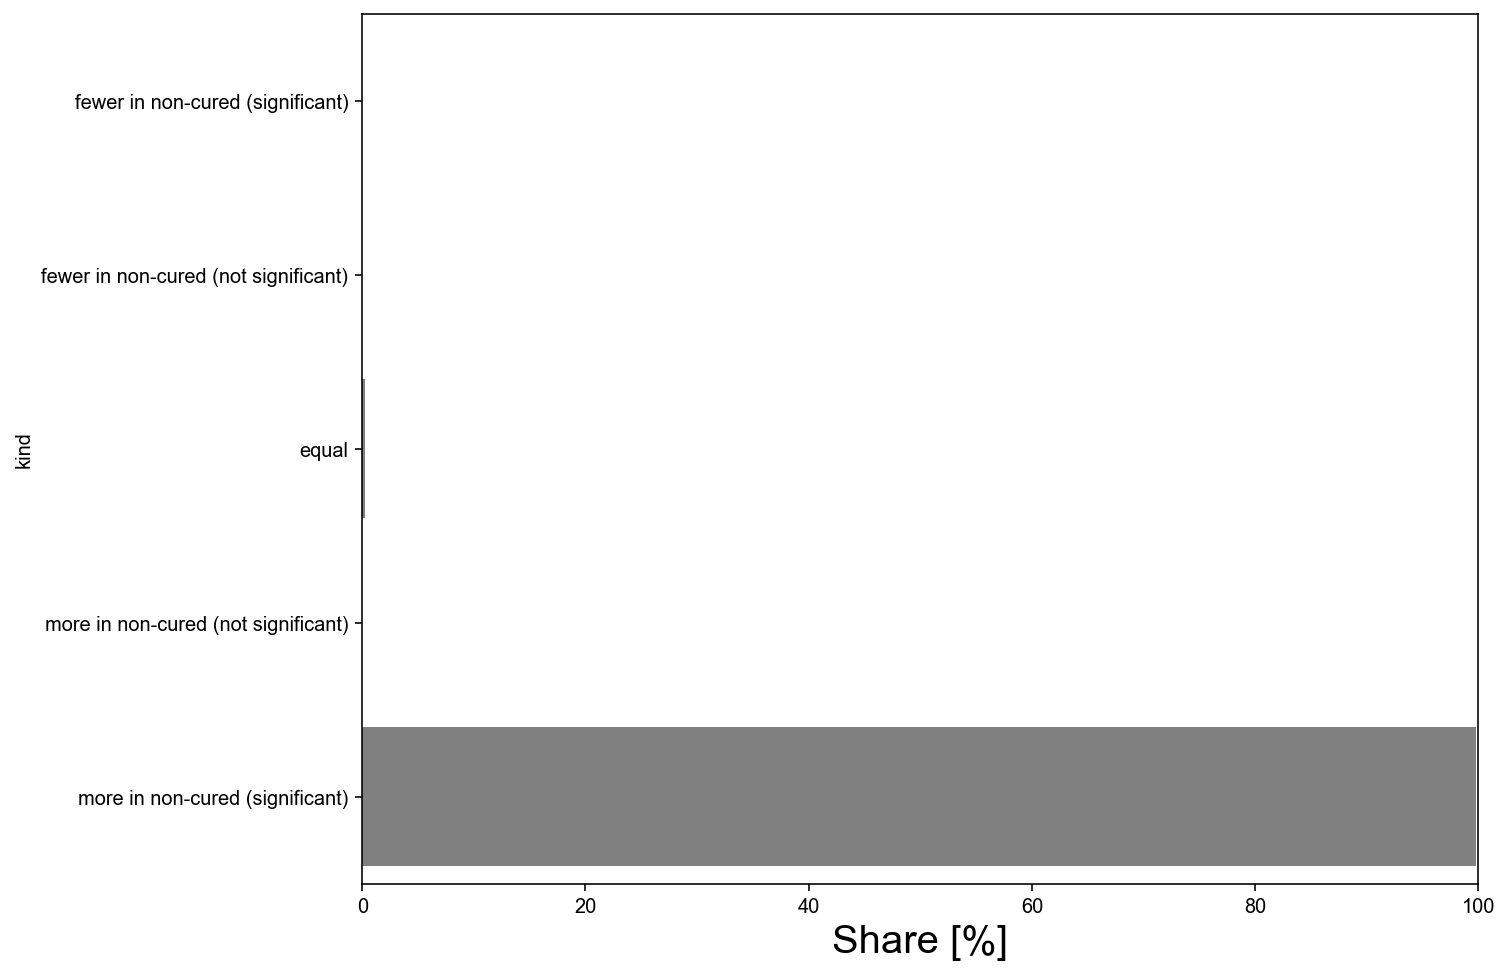

In [40]:
helper = df.copy()

sns.barplot(
    y='kind',
    x='group1_median',
    estimator=lambda x: 100*(len(x)/helper.shape[0]),
    data=helper,
    order=[
        'fewer in non-cured (significant)',
        'fewer in non-cured (not significant)',
        'equal',
        'more in non-cured (not significant)',
        'more in non-cured (significant)'
    ],


  color='grey'
)

plt.xlim(0, 100)
plt.xlabel('Share [%]', fontsize=20)

dump_figure('transitions.pdf')

In [41]:
helper['kind'].value_counts() / helper.shape[0]

more in non-cured (significant)    0.998
equal                              0.002
Name: kind, dtype: float64

In [42]:
helper['kind'].value_counts()

more in non-cured (significant)    499
equal                                1
Name: kind, dtype: int64